In [1]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'

In [ ]:
# !pip install --upgrade tensorflow

In [ ]:
!rm -rf /content/images


!rm -rf /content/labels

In [2]:
#Data Fetching
!pip install opencv-contrib-python
from IPython.display import clear_output
!unzip "/content/Images.zip" -d "/content/images"
!unzip "/content/Labels.zip" -d "/content/labels"
clear_output()

In [3]:
#Useful imports
#will remain the same
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import cv2 as cv

from tensorflow import keras
from tensorflow.keras.layers import StringLookup




np.random.seed(42)
tf.random.set_seed(42)

In [4]:
filenames_img=sorted(os.listdir('/content/images'))
filenames_gt=sorted(os.listdir('/content/labels'))
filenames_imgsplit=[filename.replace('.jpg', '') for filename in filenames_img]
filenames_gtsplit=[filename.replace('.txt', '') for filename in filenames_gt]
print(len(filenames_imgsplit))
print(len(filenames_gtsplit))

18270
18270


In [5]:
#train test validate splitting
split_idx = int(0.8 * len(filenames_imgsplit))
train_samples = filenames_img[:split_idx]
train_samples_split = filenames_imgsplit[:split_idx]
test_samples = filenames_img[split_idx:]
test_samples_split = filenames_imgsplit[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
validation_samples_split = test_samples_split[:val_split_idx]
test_samples = test_samples[val_split_idx:]
test_samples_split = test_samples_split[val_split_idx:]

assert len(filenames_imgsplit) == len(train_samples) + len(validation_samples) + len(
    test_samples
)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")
print(f' Example from training dataset {train_samples_split[0]}')

Total training samples: 14616
Total validation samples: 1827
Total test samples: 1827
 Example from training dataset 1


In [6]:
#get data and labels as lists
base_path='/content/'
base_image_path = os.path.join(base_path, "images/")
base_GT_path = os.path.join(base_path, "labels/")

def get_image_paths_and_labels(filenames_img, filenames_imgsplit):
    paths = []
    labels = []
    for i in range(len(filenames_imgsplit)):
        img_path = os.path.join(
            base_image_path,  filenames_img[i]
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            label_path = os.path.join(
            base_GT_path,  filenames_imgsplit[i]+'.txt'
        )
        label_file = open(label_path, "r")
        labels.append(label_file.read())

    return paths, labels

train_img_paths, train_labels = get_image_paths_and_labels(train_samples, train_samples_split)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples, validation_samples_split)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples, test_samples_split)

In [7]:
# Initialize variables to collect characters and track max length
train_labels_cleaned = []
characters = set()
max_len = 0

urdu_char_variants = {
    'ا': ['ا'],
    'ب': ['ب', 'بـ', 'ـب', 'ـبـ'],
    'پ': ['پ', 'پـ', 'ـپ', 'ـپـ'],
    'ت': ['ت', 'تـ', 'ـت', 'ـتـ'],
    'ث': ['ث', 'ثـ', 'ـث', 'ـثـ'],
    'ج': ['ج', 'جـ', 'ـج', 'ـجـ'],
    'چ': ['چ', 'چـ', 'ـچ', 'ـچـ'],
    'ح': ['ح', 'حـ', 'ـح', 'ـحـ'],
    'خ': ['خ', 'خـ', 'ـخ', 'ـخـ'],
    'د': ['د'],
    'ڈ': ['ڈ', 'ڈـ', 'ـڈ', 'ـڈـ'],
    'ذ': ['ذ', 'ذـ', 'ـذ', 'ـذـ'],
    'ر': ['ر'],
    'ڑ': ['ڑ', 'ڑـ', 'ـڑ', 'ـڑـ'],
    'ز': ['ز', 'زـ', 'ـز', 'ـزـ'],
    'ژ': ['ژ', 'ژـ', 'ـژ', 'ـژـ'],
    'س': ['س', 'سـ', 'ـس', 'ـسـ'],
    'ش': ['ش', 'شـ', 'ـش', 'ـشـ'],
    'ص': ['ص', 'صـ', 'ـص', 'ـصـ'],
    'ض': ['ض', 'ضـ', 'ـض', 'ـضـ'],
    'ط': ['ط', 'طـ', 'ـط', 'ـطـ'],
    'ظ': ['ظ', 'ظـ', 'ـظ', 'ـظـ'],
    'ع': ['ع', 'عـ', 'ـع', 'ـعـ'],
    'غ': ['غ', 'غـ', 'ـغ', 'ـغـ'],
    'ف': ['ف', 'فـ', 'ـف', 'ـفـ'],
    'ق': ['ق', 'قـ', 'ـق', 'ـقـ'],
    'ک': ['ک', 'کـ', 'ـک', 'ـکـ'],
    'گ': ['گ', 'گـ', 'ـگ', 'ـگـ'],
    'ل': ['ل', 'لـ', 'ـل', 'ـلـ'],
    'م': ['م', 'مـ', 'ـم', 'ـمـ'],
    'ن': ['ن', 'نـ', 'ـن', 'ـنـ'],
    'ں': ['ں', 'ںـ', 'ـں', 'ـںـ'],
    'و': ['و'],
    'ہ': ['ہ', 'ہـ', 'ـہ', 'ـہـ'],
    'ھ': ['ھ', 'ھـ', 'ـھ', 'ـھـ'],
    'ء': ['ء'],
    'ی': ['ی', 'یـ', 'ـی', 'ـیـ'],
    'ے': ['ے', 'ےـ', 'ـے', 'ـےـ'],
    '،': ['،'],
    '`ٔ': ['`ٔ'],
    ' ': [' '],
    '.': ['.'],
    ',': [','],
    '!': ['!'],
    '?': ['?'],
    ':': [':'],
    ';': [';'],
    '-': ['-'],
    'ؓ': ['ؓ'],
    'ٔ': ['ٔ'],
    'ٹ': ['ٹ', 'ٹـ', 'ـٹ', 'ـٹـ'],
    '۔': ['۔'],
    # Add your additional characters to the dictionary
    "'": ["'"], 'ئ': ['ئ'], 'آ': ['آ'], '؟': ['؟'], 'ٓ': ['ٓ'],
    '1': ['1'], '2': ['2'], '4': ['4'], '9': ['9'], '0': ['0'],
    '3': ['3'], '7': ['7'], '6': ['6'], '5': ['5'], 'َ': ['َ'],
    'ٴ': ['ٴ'], 'ٰ': ['ٰ'], '%': ['%'], '؛': ['؛'], 'ً': ['ً'],
    '(': ['('], ')': [')'], '8': ['8'], 'ْ': ['ْ'], '/': ['/'],
    '"': ['"'], 'ة': ['ة'], 'ِ': ['ِ'], 'ؤ': ['ؤ'], '۳': ['۳'],
    'ۓ': ['ۓ'], '١': ['١'], '٩': ['٩'], '٤': ['٤'], '٧': ['٧'],
    '\u200f': ['\u200f'], '٨': ['٨'], '٥': ['٥'], '٠': ['٠'],
    '٣': ['٣'], '٢': ['٢'], '٦': ['٦'], 'ه': ['ه'], '۲': ['۲'],
    '۱': ['۱'], '۴': ['۴'], 'ّ': ['ّ'], '۵': ['۵'], '۰': ['۰'],
    '۸': ['۸'], 'ُ': ['ُ'], 'ﷺ': ['ﷺ'], '۹': ['۹'], 'ٗ': ['ٗ'],
    'ﺅ': ['ﺅ'], '#': ['#'], '*': ['*'], 'A': ['A'], 'M': ['M'],
    'O': ['O'], 'L': ['L'], 'E': ['E'], 'D': ['D'], '‘': ['‘'],
    '’': ['’'], 'x': ['x'], 'k': ['k'], 'ۂ': ['ۂ'], 'ۃ': ['ۃ'],
    'ؐ': ['ؐ'], 'ؒ': ['ؒ'], '٭': ['٭'], 'ٌ': ['ٌ'], 'o': ['o'],
    'ؔ': ['ؔ'], 'أ': ['أ'], 'ي': ['ي'], 'u': ['u'], 'ﷲ': ['ﷲ'],
    'l': ['l'], ']': [']'], 'ؑ': ['ؑ']
}
# # Loop through all labels and extract characters
for label in train_labels:
    label = label.lstrip('\ufeff').strip()  # Clean up BOM and whitespace

    # Update the maximum length of labels
    max_len = max(max_len, len(label))

# Combine all forms of the characters to create the full vocabulary
characters = set()
for char, forms in urdu_char_variants.items():
    for form in forms:
        characters.add(form)

# Now your `characters` set contains all forms (isolated, initial, medial, final)
print("Vocabulary size:", len(characters))
print("Captured characters:", sorted(list(characters)))

# Print the results
print("Maximum length: ", max_len)

# Check some label samples
print(train_labels_cleaned[:10])


Vocabulary size: 236
Captured characters: [' ', '!', '"', '#', '%', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'D', 'E', 'L', 'M', 'O', ']', '`ٔ', 'k', 'l', 'o', 'u', 'x', '،', 'ؐ', 'ؑ', 'ؒ', 'ؓ', 'ؔ', '؛', '؟', 'ء', 'آ', 'أ', 'ؤ', 'ئ', 'ا', 'ب', 'بـ', 'ة', 'ت', 'تـ', 'ث', 'ثـ', 'ج', 'جـ', 'ح', 'حـ', 'خ', 'خـ', 'د', 'ذ', 'ذـ', 'ر', 'ز', 'زـ', 'س', 'سـ', 'ش', 'شـ', 'ص', 'صـ', 'ض', 'ضـ', 'ط', 'طـ', 'ظ', 'ظـ', 'ع', 'عـ', 'غ', 'غـ', 'ـب', 'ـبـ', 'ـت', 'ـتـ', 'ـث', 'ـثـ', 'ـج', 'ـجـ', 'ـح', 'ـحـ', 'ـخ', 'ـخـ', 'ـذ', 'ـذـ', 'ـز', 'ـزـ', 'ـس', 'ـسـ', 'ـش', 'ـشـ', 'ـص', 'ـصـ', 'ـض', 'ـضـ', 'ـط', 'ـطـ', 'ـظ', 'ـظـ', 'ـع', 'ـعـ', 'ـغ', 'ـغـ', 'ـف', 'ـفـ', 'ـق', 'ـقـ', 'ـل', 'ـلـ', 'ـم', 'ـمـ', 'ـن', 'ـنـ', 'ـٹ', 'ـٹـ', 'ـپ', 'ـپـ', 'ـچ', 'ـچـ', 'ـڈ', 'ـڈـ', 'ـڑ', 'ـڑـ', 'ـژ', 'ـژـ', 'ـک', 'ـکـ', 'ـگ', 'ـگـ', 'ـں', 'ـںـ', 'ـھ', 'ـھـ', 'ـہ', 'ـہـ', 'ـی', 'ـیـ', 'ـے', 'ـےـ', 'ف', 'فـ', 'ق', 'قـ', 'ل', 'لـ', 'م', 'مـ', 'ن', 'نـ', 'ه'

In [8]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.lstrip('\ufeff').strip()
        label = label.lstrip('').strip()
        cleaned_labels.append(label)
    return cleaned_labels

train_labels_cleaned = clean_labels(train_labels)
validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

print(train_labels_cleaned)
print(test_labels_cleaned)
print(validation_labels_cleaned)


["اور تھیٹر میں' پھر ایسٹ انڈیا کمپنی نے اودھ پر", 'چاول غیر ملکی زر مبادلہ حاصل کرنے والی اجناس میں دوسرے نمبر پر ہے جس', 'ٹیکس کلچر کا فروغ ملکی ترقی کے لیے اتنہائی ضروری ہے لیکن ملک میں قائم', 'ہے۔ جبکہ دائیں بازو کی جماعتیں بھی مقبولیت حاصل نہیں کر پائیں۔ محنت', 'لیں تو ہم ملک میں ڈھائی سو اسپتال بناسکتے ہیں اور یہی', 'ہے کہ حکومت پاکستان نے مشرف دور میں لئے جانے', 'فصلوں کے منصفانہ معاوضوں کا مستقل نظام قائم کیا جائے۔ جس', 'جا رہا ہے۔ رئیل سٹیٹ کے کاروبار میں مخصوص', 'سید حیدر اقبال اور ان کی ٹیم کے ممبران بھی عام لوگوں', 'اقتصادی معیشت کو چار چاند لگا دے گی جس کی', 'دیگر مسائل نے اسے بری طرح گھیر رکھا ہے اور پنجاب کی انتظامی مشینری', 'مہیا کرکے اپنی زرعی برآمدات کو جمود سے بچاتے ہیں۔ چنانچہ', 'زندگی کی رمق پیدا کی۔ ایک خوابیدہ اور بے حس معاشرے', 'کمی ہوئی ،جس کے ملکی معیشت پر منفی اثرات مرتب ہو رہے', "جمع کرتا ہے' اس کا ایک حصہ تواضع کے سامان پر خرچ ہوتا ہے", 'ہو سکتے۔ ہمارے ہاں خاص بیج اورپری بیسک بیج کے نا م پر', 'حالت میں استعمال کی جا سکتی ہے۔', 'اور پورے نہیں کرتے۔ بڑے بڑے و

In [9]:
print(characters)

{'ں', 'ـز', 'ـٹ', 'ـظ', 'عـ', 'ﷲ', 'ظ', '٨', 'ـژ', 'زـ', 'ہـ', 'l', 'ـب', 'ـحـ', '،', 'o', 'ؤ', 'شـ', 'ب', 'ضـ', 'ـغ', 'فـ', 'ـہـ', 'ـہ', 'ۂ', '۳', 'ـسـ', 'ـع', 'و', 'ي', 'ـں', 'ـطـ', 'ـص', 'M', 'ؐ', 'ژـ', 'ـڑ', 'ے', 'صـ', '!', '%', 'ـگـ', 'ق', 'ـتـ', '9', 'ؒ', 'ـصـ', 'ٹ', '?', 'ـپ', '٥', ':', 'ـیـ', '٭', 'ـذـ', 'چ', 'ض', 'ٗ', 'ء', 'A', 'ٹـ', 'ه', 'ںـ', 'ـث', '٣', 'ـض', '8', '؟', '-', 'ـضـ', 'ـژـ', '1', 'ظـ', '3', '۔', 'ۃ', 'ڈـ', 'ؔ', 'ـخـ', '5', '٤', '؛', 'ژ', 'L', 'ـبـ', '.', ')', 'k', 'ـح', 'ی', 'ـعـ', 'گ', 'ھ', '4', '٢', 'ؓ', 'ڑـ', 'َ', 'ﺅ', 'بـ', ',', 'ـمـ', 'پـ', '١', 'جـ', 'u', 'تـ', 'ـےـ', '0', '٩', 'ـزـ', 'ہ', 'ِ', 'ٰ', 'نـ', 'ۓ', 'ط', 'چـ', 'ـگ', 'ُ', 'ٴ', 'ش', 'ـنـ', 'ٌ', 'ھـ', 'ـخ', '۰', '/', 'ـلـ', '’', 'ث', 'غ', 'غـ', 'E', 'x', 'ـت', "'", '7', '۴', 'ـظـ', '`ٔ', 'ـپـ', 'ـڈ', 'ڑ', 'حـ', 'آ', 'ـجـ', 'ت', 'سـ', 'ـڑـ', 'یـ', '6', 'ّ', 'ـی', 'ذـ', 'ـڈـ', 'ڈ', 'O', 'م', 'ـس', 'کـ', ']', 'ذ', 'لـ', 'ـھـ', 'ـج', '۵', ';', 'ؑ', '"', 'طـ', 'گـ', 'پ', 'ـے', 'ـںـ', 'س', 'ع', '۲', 'ٔ',

In [10]:
import tensorflow as tf

urdu_vocabulary = sorted(characters)  # Ensure vocabulary is consistent
AUTOTUNE = tf.data.AUTOTUNE

char_to_num = tf.keras.layers.StringLookup(vocabulary=urdu_vocabulary, mask_token=None, oov_token=None)
num_to_char = tf.keras.layers.StringLookup(vocabulary=urdu_vocabulary, mask_token=None, invert=True)

# Example of how you would use these layers
example_text = "،"
example_token = char_to_num(example_text)  # Convert characters to integers
example_char = num_to_char(example_token)  # Convert integers back to characters

print(f"Original Text: {example_text}")
print(f"Converted to Integer: {example_token.numpy()}")
print(f"Converted back to Character: {example_char.numpy().decode('utf-8')}")


Original Text: ،
Converted to Integer: 40
Converted back to Character: ،


In [11]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

In [12]:
print(train_labels_cleaned)

["اور تھیٹر میں' پھر ایسٹ انڈیا کمپنی نے اودھ پر", 'چاول غیر ملکی زر مبادلہ حاصل کرنے والی اجناس میں دوسرے نمبر پر ہے جس', 'ٹیکس کلچر کا فروغ ملکی ترقی کے لیے اتنہائی ضروری ہے لیکن ملک میں قائم', 'ہے۔ جبکہ دائیں بازو کی جماعتیں بھی مقبولیت حاصل نہیں کر پائیں۔ محنت', 'لیں تو ہم ملک میں ڈھائی سو اسپتال بناسکتے ہیں اور یہی', 'ہے کہ حکومت پاکستان نے مشرف دور میں لئے جانے', 'فصلوں کے منصفانہ معاوضوں کا مستقل نظام قائم کیا جائے۔ جس', 'جا رہا ہے۔ رئیل سٹیٹ کے کاروبار میں مخصوص', 'سید حیدر اقبال اور ان کی ٹیم کے ممبران بھی عام لوگوں', 'اقتصادی معیشت کو چار چاند لگا دے گی جس کی', 'دیگر مسائل نے اسے بری طرح گھیر رکھا ہے اور پنجاب کی انتظامی مشینری', 'مہیا کرکے اپنی زرعی برآمدات کو جمود سے بچاتے ہیں۔ چنانچہ', 'زندگی کی رمق پیدا کی۔ ایک خوابیدہ اور بے حس معاشرے', 'کمی ہوئی ،جس کے ملکی معیشت پر منفی اثرات مرتب ہو رہے', "جمع کرتا ہے' اس کا ایک حصہ تواضع کے سامان پر خرچ ہوتا ہے", 'ہو سکتے۔ ہمارے ہاں خاص بیج اورپری بیسک بیج کے نا م پر', 'حالت میں استعمال کی جا سکتی ہے۔', 'اور پورے نہیں کرتے۔ بڑے بڑے و

In [13]:
empty=[]
for label in train_labels_cleaned:
    for char in label:
        if char not in urdu_vocabulary:
          empty.append(char)

empty2=[]
for i in empty:
  if i not in empty2:
    empty2.append(i)

print(empty2)

[]


In [48]:
import tensorflow as tf
AUTOTUNE = tf.data.AUTOTUNE


batch_size = 64
padding_token = 99
image_width = 512
image_height = 64

# Function to preprocess images
def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Ensure 3 channels (RGB)

    # Convert to grayscale if necessary
    if tf.shape(image)[-1] == 3:
        image = tf.image.rgb_to_grayscale(image)  # Convert to grayscale

    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]

    return image

def decode_label(vectorized_label):
    indices = tf.gather(vectorized_label, tf.where(tf.math.not_equal(vectorized_label, 0)))
    label_str = tf.strings.reduce_join(num_to_char(indices))  # Join characters
    return label_str.numpy().decode('utf-8')


def vectorize_label(label, max_len=116, padding_token=0):
    # print(f"Original Label: {label}")
    label_chars = tf.strings.unicode_split(label, input_encoding="UTF-8")
    label_indices = char_to_num(label_chars)
    length = tf.shape(label_indices)[0]
    pad_amount = max_len - length
    label_indices = tf.pad(label_indices, paddings=[[0, pad_amount]], constant_values=padding_token)

    return label_indices

# Example usage with a label
label = vectorize_label(train_labels_cleaned[0], max_len=116)
print(f"Vectorized Label: {label}")
indices = tf.gather(label, tf.where(tf.math.not_equal(label, 0)))
label_str = tf.strings.reduce_join(num_to_char(indices))
decoded_label = decode_label(label)
print(f"Decoded Label: {decoded_label}")


Vectorized Label: [ 53 168  70   1  57 211 217 193  70   1 163 217 209   6   1 195 211  70
   1  53 217  73 193   1  53 165 199 217  53   1 205 163 195 165 217   1
 165 219   1  53 168  67 211   1 195  70   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0]
Decoded Label: اور تھیٹر میں' پھر ایسٹ انڈیا کمپنی نے اودھ پر


In [15]:
# Function to process both images and labels
def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)  # Vectorize the cleaned label
    return {"image": image, "label": label}

# Function to prepare the dataset
def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)



In [ ]:
# print(train_img_paths)

In [16]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)


Original Label: Tensor("args_1:0", shape=(), dtype=string)
Original Label: Tensor("args_1:0", shape=(), dtype=string)
Original Label: Tensor("args_1:0", shape=(), dtype=string)


In [ ]:
# for image, label in train_ds.take(1):  # Taking 1 batch from train_ds
#     tf.print("Image shape:", image.shape)
#     tf.print("Label shape:", label.shape)

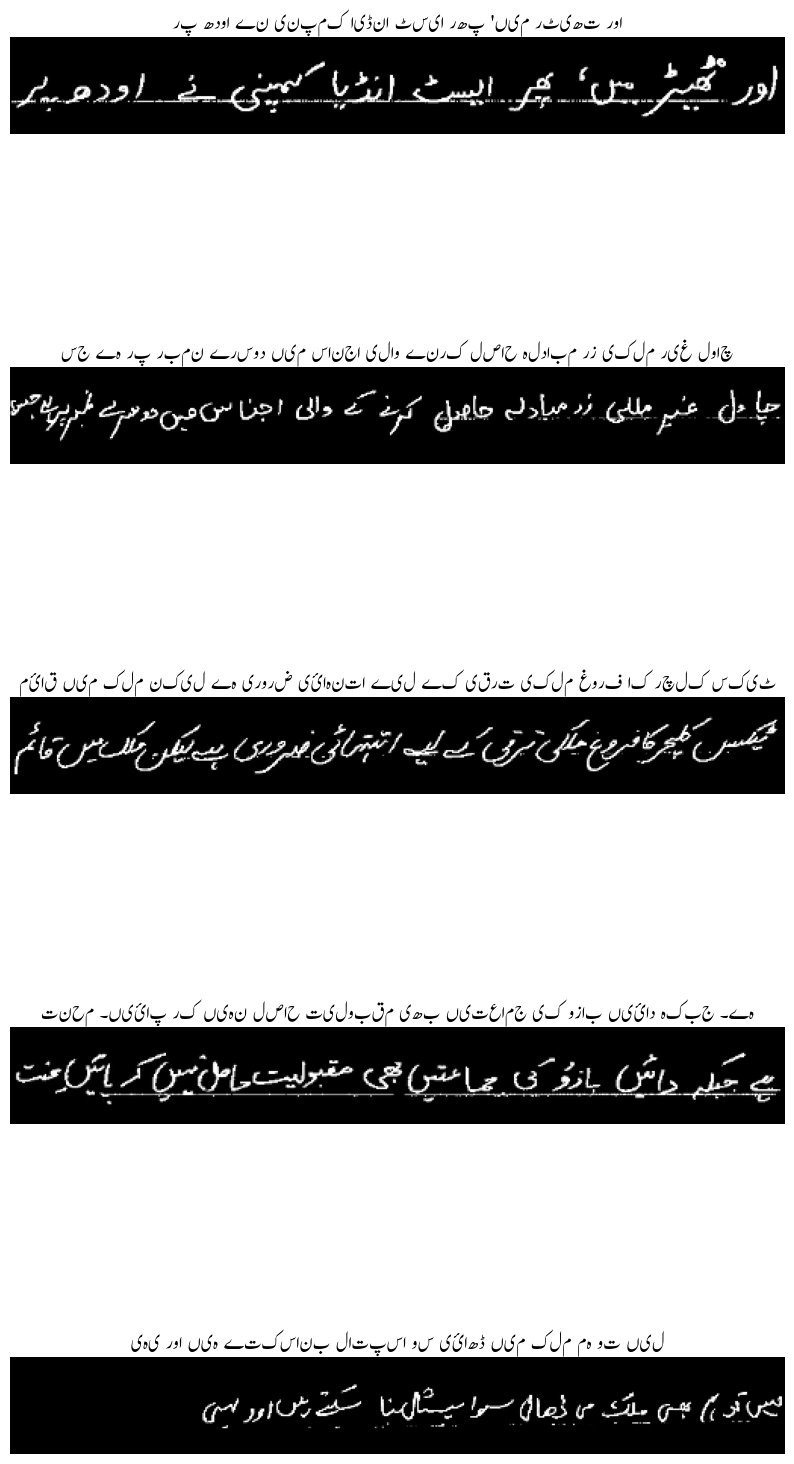

In [17]:
import os
import tensorflow as tf
import numpy as np
from matplotlib import font_manager as fm, rcParams
import matplotlib.pyplot as plt

# Path to your Urdu font file (adjust the path accordingly)
font_path = '/content/jameel_noori.ttf'  # Change this path based on where your font file is

# Load the font using FontProperties
prop = fm.FontProperties(fname=font_path)

# Assuming you already have train_ds and decode_label function defined
for data in train_ds.take(1):  # Adjusting to take only one batch
    images, labels = data["image"], data["label"]

    # Create a figure with 5 rows and 1 column for readability and larger images
    _, ax = plt.subplots(5, 1, figsize=(10, 20))  # Increase figure size to make images larger

    for i in range(5):  # Plot only 5 images
        img = images[i]
        img = tf.image.rot90(img, k=2)
        img = tf.transpose(img, perm=[1, 0, 2])  # Adjust dimensions
        img = tf.image.flip_left_right(img)  # Flip horizontally
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)  # Normalize and convert to uint8
        img = img[:, :, 0]  # Use single channel for grayscale

        # Decode the label into a full sentence
        label = labels[i]
        decoded_label = decode_label(label)

        # Set the title using your custom font
        ax[i].imshow(img, cmap="gray")
        ax[i].set_title(decoded_label[::-1], fontproperties=prop, fontsize=16)  # Reverse for Urdu display
        ax[i].axis("off")

    # Adjust spacing between subplots
    plt.subplots_adjust(hspace=0.5)  # Add more space between rows
    plt.show()


In [18]:
# Iterate through one batch of the dataset
for batch in validation_ds.take(1):
    images = batch["image"]
    print(images.shape)  # This will print the shape of the images in the batch


(64, 512, 64, 1)


In [19]:
# Iterate through one batch of the dataset
for batch in train_ds.take(1):
    images = batch["image"]
    # labels = batch["label"]
    print(images.shape)  # This will print the shape of the images in the batch

(64, 512, 64, 1)


In [20]:
# Iterate through one batch of the dataset
for batch in test_ds.take(1):
    images = batch["image"]
    print(images.shape)  # This will print the shape of the images in the batch

(64, 512, 64, 1)


In [ ]:
# # import tensorflow as tf
# # from tensorflow import keras

# # Custom CTC Loss Layer
# class CTCLayer(keras.layers.Layer):
#     def __init__(self, name=None):
#         super().__init__(name=name)
#         self.loss_fn = tf.keras.backend.ctc_batch_cost

#     def call(self, y_true, y_pred):
#         batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")

#         # The length of the input sequence should be based on the output width of the CNN.
#         input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")  # Shape: [batch_size, timesteps, num_classes]
#         label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

#         # Create constant tensors for batch size (input and label length)
#         input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
#         label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

#         # Compute the CTC loss
#         loss = self.loss_fn(y_true, y_pred, input_length, label_length)

#         # Add the loss to the layer
#         self.add_loss(loss)

#         # Return the predictions for further use (like in inference)
#         return y_pred



In [21]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


def build_model():
    input_img = keras.Input(shape=(512, 64, 1), name="image")  # 512x64 grayscale image
    labels = keras.layers.Input(name="label", shape=(None,), dtype=tf.int32)  # Sparse labels

    # First Conv Block (output depth=32)
    x = keras.layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv1")(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)  # Reduces height to 256
    x = keras.layers.BatchNormalization()(x)

    # Second Conv Block (output depth=64)
    x = keras.layers.Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv2")(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)  # Reduces height to 128
    x = keras.layers.BatchNormalization()(x)

    # Third Conv Block (output depth=128)
    x = keras.layers.Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv3")(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool3")(x)  # Reduces height to 64
    x = keras.layers.BatchNormalization()(x)

    # Reshape for LSTM layer (output shape after Conv layers is (None, 64, 128))
    x = keras.layers.Reshape(target_shape=(-1, 128), name="reshape")(x)  # Sequence length reduced, features=128

    # Bidirectional LSTM layer
    x = keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True, dropout=0.4))(x)

    # x = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True, dropout=0.35))(x)

    # Output layer for CTC
    x = keras.layers.Dense(len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense3")(x)

    # Apply CTCLayer for loss computation
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(inputs=[input_img, labels], outputs=output, name="handwriting_recognizer")

    # Optimizer
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.002,
        decay_steps=10000,
        decay_rate=0.9
    )
    opt = keras.optimizers.Adam(learning_rate=lr_schedule)

    # opt = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

    # Compile the model
    model.compile(optimizer=opt)
    return model


# Get the model.
model = build_model()
model.summary()

Model: "handwriting_recognizer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)        │ (None, 512, 64, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 512, 64, 32)    │            320 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 256, 32, 32)    │              0 │ Conv1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 32, 32)    │            128 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv2 (Conv2D)            │ (None, 256, 32, 64)    │         18,496 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool2 (MaxPooling2D)      │ (None, 128, 16, 64)    │              0 │ Conv2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 16, 64)    │            256 │ pool2[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv3 (Conv2D)            │ (None, 128, 16, 128)   │         73,856 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool3 (MaxPooling2D)      │ (None, 64, 8, 128)     │              0 │ Conv3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 8, 128)     │            512 │ pool3[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 512, 128)       │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 512, 512)       │        788,480 │ reshape[0][0]          │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ label (InputLayer)        │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense3 (Dense)            │ (None, 512, 239)       │        122,607 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ctc_loss (CTCLayer)       │ (None, 512, 239)       │              0 │ label[0][0],           │
│                           │                        │                │ dense3[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,004,655 (3.83 MB)

 Trainable params: 1,004,207 (3.83 MB)

 Non-trainable params: 448 (1.75 KB)

In [22]:
# Iterate through one batch of the validation dataset to check shapes
for batch in validation_ds.take(1):
    images = batch["image"]
    labels = batch["label"]

    print("Images shape:", images.shape)  # Shape of input images
    print("Labels shape:", labels.shape)  # Shape of labels

Images shape: (64, 512, 64, 1)
Labels shape: (64, 116)


In [23]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

In [24]:
for data in validation_ds.take(1):
    images = data["image"]
    print(f"Shape of images: {images.shape}")  # Ensure this is (batch_size, 512, 64, 1)


Shape of images: (64, 512, 64, 1)


In [25]:
def calculate_character_accuracy(labels, predictions, max_len=116):
    # Convert dense labels to sparse tensors
    sparse_labels = tf.sparse.from_dense(labels)

    # Define input length (assuming it's the same for all images in the batch)
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]

    # Decode predictions using CTC decode
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]  # Get the first decoded result and trim to max_len

    # Convert predictions to sparse tensor
    sparse_predictions = tf.sparse.from_dense(predictions_decoded)

    # Convert sparse tensors to dense tensors for comparison
    dense_preds = tf.sparse.to_dense(sparse_predictions, default_value=-1)
    dense_labels = tf.sparse.to_dense(sparse_labels, default_value=-1)

    # Pad both tensors to match shapes
    max_seq_len = tf.maximum(tf.shape(dense_preds)[1], tf.shape(dense_labels)[1])
    dense_preds = tf.pad(dense_preds, [[0, 0], [0, max_seq_len - tf.shape(dense_preds)[1]]], constant_values=-1)
    dense_labels = tf.pad(dense_labels, [[0, 0], [0, max_seq_len - tf.shape(dense_labels)[1]]], constant_values=-1)

    # Calculate matches (check if predicted characters match the true labels)
    matches = dense_preds == dense_labels

    # Mask padding areas (-1 in sparse representation)
    mask = tf.not_equal(dense_labels, -1)
    correct = tf.reduce_sum(tf.cast(matches & mask, tf.float32))  # Sum of correct matches
    total = tf.reduce_sum(tf.cast(mask, tf.float32))  # Total non-padding elements

    # Calculate character accuracy
    accuracy = (correct / total) if total > 0 else 0.0

    return accuracy


class CharacterAccuracyCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        accuracies = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            accuracy = calculate_character_accuracy(labels, predictions)
            accuracies.append(accuracy.numpy())

        print(f"Mean character accuracy for epoch {epoch + 1}: {np.mean(accuracies):.4f}")




In [29]:
epochs = 10  # To get good results this should be at least 50.

model = build_model()
model.load_weights('model_weights.weights.h5')
prediction_model = keras.models.Model(
    model.input[0], model.get_layer(index=-2).output
)
accuracy_callback = CharacterAccuracyCallback(prediction_model)

stopping=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[accuracy_callback],
    shuffle=True
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 1 variables whereas the saved optimizer has 41 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━

KeyboardInterrupt: 

In [30]:
model.save_weights('model_weights.weights.h5')


# from google.colab import files
# files.download('model_weights.weights.h5')

In [ ]:
# # Verify shapes for validation data (not part of the training process).
# for data in validation_ds.take(1):
#     print("Validation image shape:", data["image"].shape)

# # Optionally, perform validation (e.g., calculate loss or evaluate accuracy).
# val_loss = model.evaluate(validation_ds)
# print(f"Validation Loss: {val_loss}")


In [ ]:
# test_images = validation_images[0]
# predictions = prediction_model(test_images, training=False)
# print(f"Predictions shape: {predictions.shape}")

In [31]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    print(output_text)
    return output_text

In [53]:
import tensorflow as tf
import numpy as np

# Initialize variables for accuracy calculation
accuracies = []

# Process test dataset (example with one batch)
for batch in test_ds.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    # pred_label_vector = vectorize_label(pred_texts)

    # Debug: Check the lengths of batch_labels and pred_texts
    print(f"Batch size: {len(batch_images)}")
    print(f"Predicted texts length: {len(pred_texts)}")
    print(f"Labels length: {len(batch_labels)}")

    # Ensure we don't go out of bounds
    for i in range(len(batch_images)):
        # Check if the label and prediction exist for the current index
        if i < len(batch_labels) and i < len(pred_texts):
            print(f"Processing index {i}:")
            print(f"Prediction: {pred_texts[i]}")
            print(f"Label: {batch_labels[i]}")

            # Ensure predictions are tensors
            pred_tensor = tf.strings.unicode_split(pred_texts[i], input_encoding='UTF-8')
            # p_label = vectorize_label(pred_tensor)
            # print(f"vectorized prediction: {pred_label_vector}")
            # Calculate accuracy for each sample
            accuracy = calculate_character_accuracy(batch_labels[i], pred_tensor)
            accuracies.append(accuracy.numpy())  # Convert tensor to numpy value
        else:
            print(f"Skipping index {i} due to mismatch in lengths.")

# Calculate mean accuracy for the test dataset
if accuracies:  # Check if accuracies list is not empty
    mean_accuracy = np.mean(accuracies)
    print(f"Mean Accuracy on Test Data: {mean_accuracy:.2f}%")
else:
    print("No valid accuracies computed.")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
['ک[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]', 'ک[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]', 'ک[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK

IndexError: tuple index out of range

In [54]:
# Initialize variables for edit distance and accuracy calculation
# edit_distances = []
accuracies = []

# Iterate through the test dataset
for batch in test_ds:  # Assuming test_ds is the test dataset
    batch_images = batch["image"]
    batch_labels = batch["label"]

    # Get predictions from the inference model
    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    # Decode ground truth labels
    true_texts = decode_batch_predictions(batch_labels)

    # Loop through each sample in the batch
    for i in range(10):
        # Calculate edit distance for each sample
        # edit_distance = calculate_edit_distance(true_texts[i], pred_texts[i]).numpy()
        # edit_distances.append(edit_distance)

        # Calculate accuracy for each sample (if applicable)
        accuracy = calculate_character_accuracy(true_texts[i], pred_texts[i]).numpy()
        accuracies.append(accuracy)

# Compute mean edit distance and accuracy for the test dataset
# mean_edit_distance = np.mean(edit_distances)
mean_accuracy = np.mean(accuracies)

# print(f"Mean Edit Distance on Test Data: {mean_edit_distance:.4f}")
print(f"Mean Accuracy on Test Data: {mean_accuracy:.2f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
['ا[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]', 'ک[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]', 'ک[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK

InvalidArgumentError: {{function_node __wrapped__Transpose_device_/job:localhost/replica:0/task:0/device:GPU:0}} transpose expects a vector of size 2. But input(1) is a vector of size 3 [Op:Transpose]

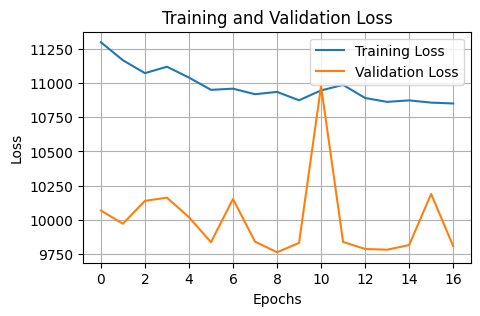

In [37]:
# plt.plot(history.history['val_loss'][2:len(history.history['val_loss'])-1])
# plt.plot(history.history['loss'][2:len(history.history['loss'])-1])

plt.figure(figsize=(5, 3))
plt.plot(history.history['loss'][2:-1], label='Training Loss')
plt.plot(history.history['val_loss'][2:-1], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

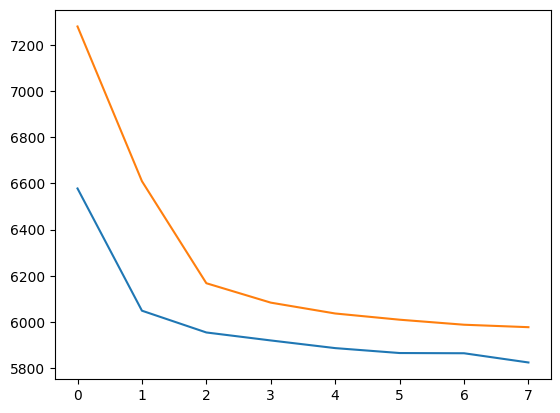

In [ ]:
plt.plot(history.history['val_loss'][1:len(history.history['val_loss'])-1])
plt.plot(history.history['loss'][1:len(history.history['loss'])-1])

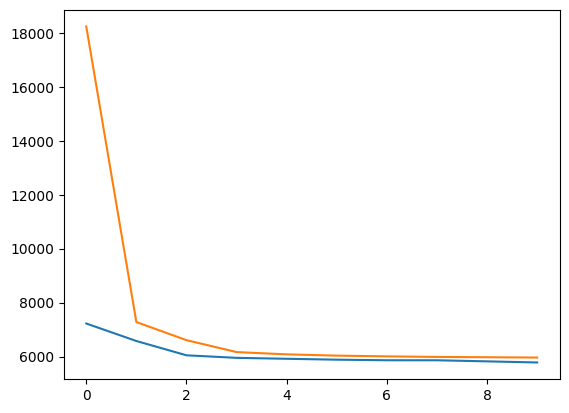

In [ ]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])